## Problem statement

We want to predict the grades of students given features such as gender, parental education, race and test prep course. Additionally, we will rank these features in terms of their contribution to the final prediction.

The dataset has grades for 3 different categories - math, reading , writing. We will combine these three scores and map these to a grading scheme (usually followed in most institutions). The problem will then be reduced to a classification problem.
This is a multi-class classification problem (6 classes for each letter grade).Therefore, we will use the following 2 classification algorithms for predicting these classes:
1. Logistic Regression
2. Support Vector Machines (SVMs)


In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
data=pd.read_csv('StudentsPerformance.csv')

Because there is a high level of correlation between the 3 scores (determined in the data analysis) we can combine these to form a final percentage score.

In [38]:
data['Percentage'] = round((data['reading score'] + data['writing score'] + data['math score']) / 3, 2)

In [39]:
def Grade(percentage):
    if percentage >= 93: return "A"
    if percentage > 81 : return "B"
    if percentage > 71 : return "C"
    if percentage > 61 : return "D"
    else: return "F"

data["Grade"] = data['Percentage'].apply(lambda x: Grade(x))

In [40]:
data.tail()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Percentage,Grade
995,female,group E,master's degree,standard,completed,88,99,95,94.00,A
996,male,group C,high school,free/reduced,none,62,55,55,57.33,F
997,female,group C,high school,free/reduced,completed,59,71,65,65.00,D
998,female,group D,some college,standard,completed,68,78,77,74.33,C
999,female,group D,some college,free/reduced,none,77,86,86,83.00,B


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race/ethnicity               1000 non-null   object 
 2   parental level of education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test preparation course      1000 non-null   object 
 5   math score                   1000 non-null   int64  
 6   reading score                1000 non-null   int64  
 7   writing score                1000 non-null   int64  
 8   Percentage                   1000 non-null   float64
 9   Grade                        1000 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 78.3+ KB


In [81]:
data['race/ethnicity'].value_counts()

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64

<Axes: xlabel='Grade', ylabel='Percentage'>

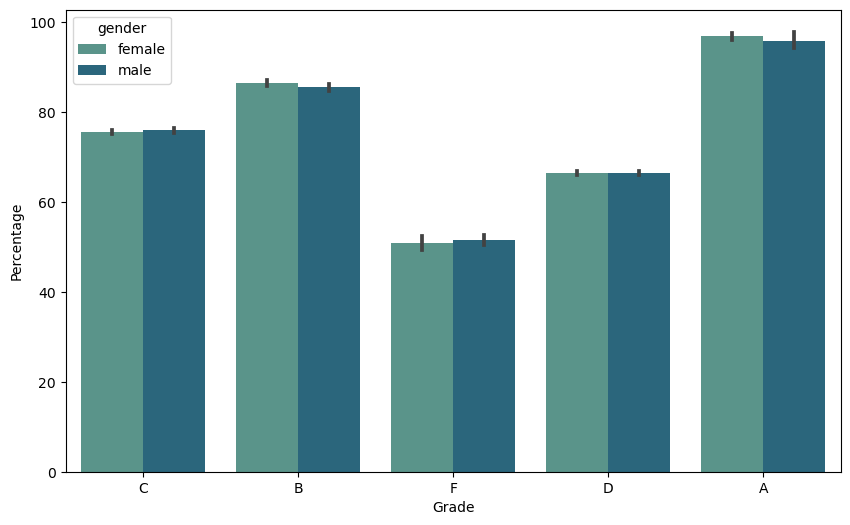

In [74]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Grade', y = 'Percentage', data= data, hue= 'gender', palette= 'crest')

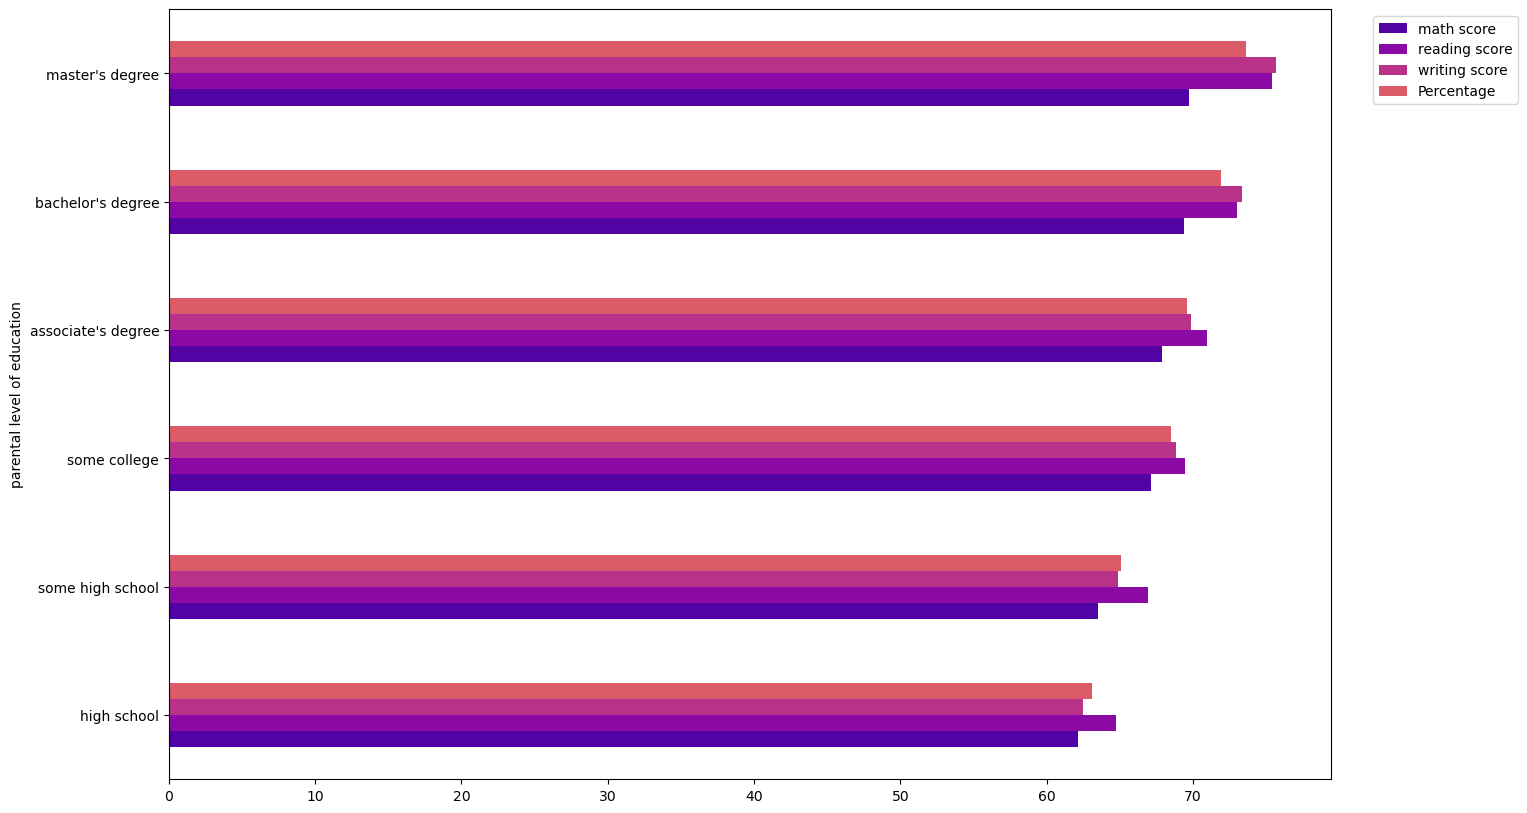

In [43]:
sns.set_palette("plasma")
data.groupby('parental level of education').agg('mean').sort_values(by = 'Percentage').plot(kind='barh',figsize=(15,10))
plt.legend(bbox_to_anchor=(1.03, 1), loc = 2)

## Encoding Categorical Variables

In [44]:
#Identify input and target columns
input_cols,target_cols=data.columns[:-5],data.columns[-1]


In [45]:
input_df,targets=data[input_cols].copy(),data[target_cols].copy()

In [46]:
input_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none


In [47]:
targets.head()

0    C
1    B
2    B
3    F
4    C
Name: Grade, dtype: object

In [48]:
categorical_cols=data[input_cols].select_dtypes(include='object').columns.tolist()

In [49]:
categorical_cols

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [50]:
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore').fit(input_df[categorical_cols])
encoded_cols=list(encoder.get_feature_names_out(categorical_cols))
input_df[encoded_cols]=encoder.transform(input_df[categorical_cols])

In [51]:
input_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,...,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,female,group B,bachelor's degree,standard,none,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,female,group C,some college,standard,completed,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,female,group B,master's degree,standard,none,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,male,group A,associate's degree,free/reduced,none,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,male,group C,some college,standard,none,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [60]:
X_train,X_test,y_train,y_test=train_test_split(input_df[encoded_cols],targets,test_size=0.10,random_state=42)

In [61]:
X_train.head()

,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
716,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
351,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
936,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
256,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
635,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [80]:
X_train.describe()

,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.522222,0.477778,0.087778,0.191111,0.321111,0.253333,0.146667,0.223333,0.117778,0.204444,0.061111,0.216667,0.176667,0.350000,0.650000,0.356667,0.643333
std,0.499784,0.499784,0.283129,0.393395,0.467163,0.435162,0.353970,0.416712,0.322524,0.403519,0.239667,0.412203,0.381598,0.477235,0.477235,0.479282,0.479282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
y_train.head()

716    C
351    F
936    F
256    D
635    D
Name: Grade, dtype: object

In [63]:
print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

X_train dimension=  (900, 17)
X_test dimension=  (100, 17)
y_train dimension=  (900,)
y_train dimension=  (100,)


## Multiclass Logistic Regression using OVR(One versus rest)

Since we are going to use One Vs Rest algorithm, we will set multi_class='ovr'
Note: since we are using One Vs Rest algorithm we must use 'liblinear' solver with it (check sklearn documentation).

In [64]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [65]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [66]:
print(lm.score(X_test, y_test))

0.39


In [67]:
print(metrics.classification_report(y_test, lm.predict(X_test)))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.33      0.08      0.12        13
           C       0.34      0.37      0.35        30
           D       0.24      0.17      0.20        24
           F       0.48      0.72      0.57        32

    accuracy                           0.39       100
   macro avg       0.28      0.27      0.25       100
weighted avg       0.36      0.39      0.35       100



In [68]:
#Predict for any one value using the model
predicted= lm.predict(X_test)

In [69]:
df_new=pd.DataFrame(predicted,y_test)

In [70]:
df_new.head()

,0
Grade,
B,C
D,D
C,D
C,F
B,B


As can be clearly seen, Logistic regression performs poorly on this dataset. One of the reasons could be class imbalance as shown below:

In [75]:
data['Grade'].value_counts()

F    314
D    263
C    246
B    147
A     30
Name: Grade, dtype: int64

One way to deal with this issue is to use models that can handle imbalanced classes better for example decision trees.

## Decision Tree Classifier

In [76]:
from sklearn.tree import DecisionTreeClassifier

In [77]:
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)


In [79]:
print(metrics.classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.05      0.08      0.06        13
           C       0.26      0.33      0.29        30
           D       0.23      0.12      0.16        24
           F       0.41      0.38      0.39        32

    accuracy                           0.26       100
   macro avg       0.19      0.18      0.18       100
weighted avg       0.27      0.26      0.26       100



Issue with both the models:
https://stats.stackexchange.com/questions/179995/can-i-fit-logistic-regression-over-a-dataset-with-only-categorical-data